In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import requests
from io import BytesIO
import numpy as np


In [4]:
# 1. Load your own image
url=r"https://imgs.search.brave.com/QzEUQY2l8yNYl3hVyCPgckvJbQBNZjkVZQBCZBOjBeQ/rs:fit:500:0:1:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZXR0eWltYWdl/cy5jb20vaWQvMTg1/MzA0Mjc0L3Bob3Rv/L2tpdHRlbi5qcGc_/cz02MTJ4NjEyJnc9/MCZrPTIwJmM9WFpZ/NVVsUEdrTEhCSGst/cFlUMGQzNm81NGdO/VW0tWW5RcWYtLTNi/MkU5QT0"
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=(128, 128))
img = img_to_array(img) / 255.0  # normalize 0–1
img = np.expand_dims(img, axis=0)  # shape → (1, 128,128,3)

In [5]:
# 2. Create noisy image
noise_factor = 0.4
noisy_img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
noisy_img = np.clip(noisy_img, 0., 1.)

In [6]:
# 3. Autoencoder model
input_img = Input(shape=(128,128,3))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

In [8]:
# Decoder
x = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

In [10]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 4. Train the autoencodr
autoencoder.fit(noisy_img, img, epochs=2000, verbose=0)
# (High epochs because training with a single image)

In [12]:
# 5. Predict the output
reconstructed = autoencoder.predict(noisy_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


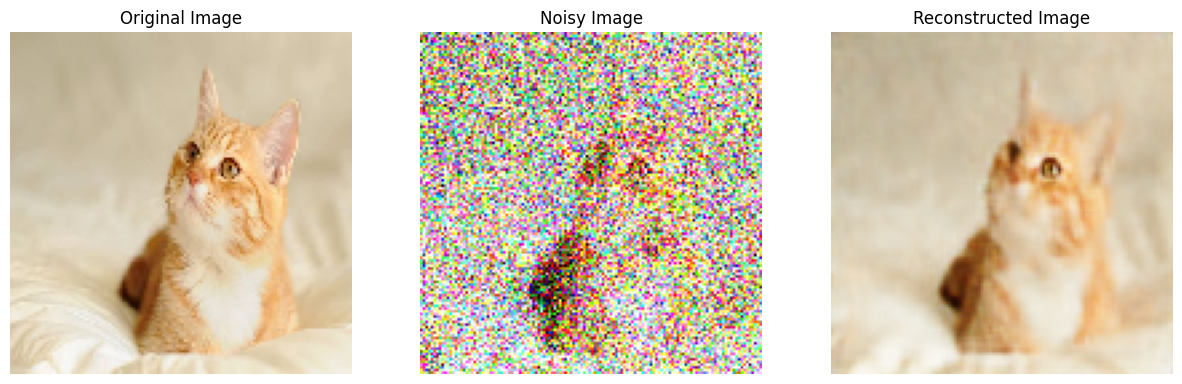

In [13]:
# 6. Show Original → Noisy → Reconstructed
plt.figure(figsize=(15,5))

# Original
plt.subplot(1,3,1)
plt.imshow(img[0])
plt.title("Original Image")
plt.axis("off")

# Noisy
plt.subplot(1,3,2)
plt.imshow(noisy_img[0])
plt.title("Noisy Image")
plt.axis("off")

# Reconstructed
plt.subplot(1,3,3)
plt.imshow(reconstructed[0])
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()